### Objective: To calcaulate the hydrophobicity of the antibodies using different hydrophobicity scales
I previously calculated hydrophobicity for therapeutic antibodies for the therapeutic antibodies using the Eisenberg scale. 
Here, I am usin different scales to calculate the hydrophobicity. Eisenberg is supposed to be not very good for this. 


##### Import modules

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from itertools import product
from developability.utils import ls, extract_sequence_from_pdb, plot_correlogram
from developability.hydrophobicity import HydrophobicSurface, region_hydrophobicities, read_hydrophobicity_scales
from developability.descriptors import annotate_residues_with_fv_regions
from dask import delayed, compute
from tqdm.notebook import tqdm
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)


In [2]:
def compute_hydrophobicity(path, scale, weight, radius):
    name = path.name.split('_')[0]
    pdb = path/'pdb4amber.pdb'
    sequences = extract_sequence_from_pdb(pdb)
    pqr = [f for f in ls(path) if f.name.endswith('.pqr')][0]
    atom_surface = path/'triangulatedSurf.atom.csv'
    
    hydro = HydrophobicSurface(pqr, atom_surface,radius=radius, weight=weight, scale=scale)

    residue_hydrophobicity = hydro.residue_hydrophobicities
    residue_hydrophobicity = annotate_residues_with_fv_regions(sequences, residue_hydrophobicity, scheme = 'kabat')
    
    residue_hydrophobicity.to_csv(path/f'residue_hydrophobicity_scale_{scale}_weight_{weight}_radius_{radius}.csv')
    df = pd.DataFrame(region_hydrophobicities(residue_hydrophobicity), index=[name])
    df.index = df.index.rename('antibody')

    return df


def parallelize_hydrophobicity(paths, scale, weight, radius):
    dfs = []
    batches = np.array_split(paths,10)
    for batch in tqdm(batches, total = len(batches)):
        tasks  = [delayed(compute_hydrophobicity)(path, scale, weight, radius) for path in batch]
        dfs.extend([task for task in compute(*tasks, scheduler='processes')])
        
    df = pd.concat(dfs)
    df['scale'] = scale
    df['weight'] = weight
    df['radius'] = radius

    output_path = paths[0].parent
    df.to_csv(output_path/f'hydrophobicity_scale_{scale}_weight_{weight}_radius_{radius}.csv')
    return df


def cartesian_product(dict_of_lists):
    """ Create the Cartesian product of a dictionary of lists
    Args:
        dict_of_lists (dict): The dictionary of lists
    Returns:
        pandas.DataFrame: The Cartesian product as a DataFrame
    """

    # Get the keys and lists from the dictionary
    keys = dict_of_lists.keys()
    lists = dict_of_lists.values()

    # Get the Cartesian product of the lists
    cartesian_product = list(product(*lists))

    # Create a DataFrame from the Cartesian product
    df = pd.DataFrame(cartesian_product, columns=keys)

    return df


#### Run the above pipeline for uniform aggregation and the following hydrophobicity scales only. 

In [3]:
hydro_table = read_hydrophobicity_scales()
cols = ['Kyte_Doolittle', 'Eisenberg', 'Rose', 'BaMe',
        'BlMo', 'Ei', 'KyDo', 'Me', 'Ro', 'WiWh', 'Ja', 'Mi']

In [4]:
params = dict(
    scale = cols,
    weight = ['uniform'],
    radius = [0.5, 1]
)

params = cartesian_product(params)
params.head()



,scale,weight,radius
0,Kyte_Doolittle,uniform,0.5
1,Kyte_Doolittle,uniform,1.0
2,Eisenberg,uniform,0.5
3,Eisenberg,uniform,1.0
4,Rose,uniform,0.5


In [5]:
base_path = Path("/Users/ChristopherRivera/Documents/DataResults")
data_path = base_path /"TherapeuticAntibodies"


predicted_path = data_path/'AbodyBuilder2_predicted_renumbered_stuctures'
paths = [p for p in ls(predicted_path) if p.is_dir() and 'outputs' in p.name]
paths[:5]

[PosixPath('/Users/ChristopherRivera/Documents/DataResults/TherapeuticAntibodies/AbodyBuilder2_predicted_renumbered_stuctures/clazakizumab_outputs'),
 PosixPath('/Users/ChristopherRivera/Documents/DataResults/TherapeuticAntibodies/AbodyBuilder2_predicted_renumbered_stuctures/seribantumab_outputs'),
 PosixPath('/Users/ChristopherRivera/Documents/DataResults/TherapeuticAntibodies/AbodyBuilder2_predicted_renumbered_stuctures/ocrelizumab_outputs'),
 PosixPath('/Users/ChristopherRivera/Documents/DataResults/TherapeuticAntibodies/AbodyBuilder2_predicted_renumbered_stuctures/fletikumab_outputs'),
 PosixPath('/Users/ChristopherRivera/Documents/DataResults/TherapeuticAntibodies/AbodyBuilder2_predicted_renumbered_stuctures/patritumab_outputs')]

In [8]:
results = []
file_name = data_path/'hydrophobicity_scales_scan_results_12-01-2023.csv'
rerun = False
if not file_name.exists() or rerun:
    for _, row in tqdm(params.iterrows(), total=params.shape[0]):
        scale = row['scale']
        weight = row['weight']
        radius = row['radius']
        output_path = paths[0].parent
        f = output_path/f'hydrophobicity_scale_{scale}_weight_{weight}_radius_{radius}.csv'
        if not f.exists() or rerun:
            df = parallelize_hydrophobicity(paths, scale, weight, radius)
            results.append(df)
        else:
            results.append(pd.read_csv(f))


    results_df = pd.concat(results)
    results_df.to_csv(data_path/'hydrophobicity_scales_scan_results_12-01-2023.csv')
else:
    results_df = pd.read_csv(file_name)
    results_df = results_df.set_index(['antibody', 'scale', 'weight', 'radius'])

In [11]:
results_df = results_df.sort_index()
results_df.head()

HCDR1_HYDRO_pos  HCDR1_HYDRO_neg  \
antibody   scale weight  radius                                     
abituzumab BaMe  uniform 0.5            3.371330         0.000000   
                         1.0            3.338927         0.000000   
           BlMo  uniform 0.5            2.398608        -0.386229   
                         1.0            2.330686        -0.363366   
           Ei    uniform 0.5            0.797034        -0.711474   

                                 HCDR1_HYDRO_net  HCDR2_HYDRO_pos  \
antibody   scale weight  radius                                     
abituzumab BaMe  uniform 0.5            3.371330        10.561492   
                         1.0            3.338927        10.451603   
           BlMo  uniform 0.5            2.012379         6.468075   
                         1.0            1.967320         5.898450   
           Ei    uniform 0.5            0.085560         1.377163   

                                 HCDR2_HYDRO_neg  HCDR2_HYDRO_net  \
antibody   scale weight  radius                                     
abituzumab BaMe  uniform 0.5           -0.477865        10.083627   
                         1.0           -0.459965         9.991637   
           BlMo  uniform 0.5           -6.945442        -0.477367   
                         1.0           -6.570045        -0.671595   
           Ei    uniform 0.5          -14.964872       -13.587710   

                                 HCDR3_HYDRO_pos  HCDR3_HYDRO_neg  \
antibody   scale weight  radius                                     
abituzumab BaMe  uniform 0.5            5.907180        -0.122406   
                         1.0            5.794934         0.000000   
           BlMo  uniform 0.5            3.691890        -2.233317   
                         1.0            3.371910        -2.025993   
           Ei    uniform 0.5            0.944400        -4.567111   

                                 HCDR3_HYDRO_net  HFR1_HYDRO_pos  \
antibody   scale weight  radius                                    
abituzumab BaMe  uniform 0.5            5.784773       14.519673   
                         1.0            5.794934       12.998096   
           BlMo  uniform 0.5            1.458573        6.732305   
                         1.0            1.345917        6.090746   
           Ei    uniform 0.5           -3.622710        1.429674   

                                 HFR1_HYDRO_neg  HFR1_HYDRO_net  \
antibody   scale weight  radius                                   
abituzumab BaMe  uniform 0.5          -3.713924       10.805748   
                         1.0          -3.448297        9.549799   
           BlMo  uniform 0.5          -9.462063       -2.729758   
                         1.0          -9.604232       -3.513486   
           Ei    uniform 0.5         -17.574014      -16.144340   

                                 HFR2_HYDRO_pos  HFR2_HYDRO_neg  \
antibody   scale weight  radius                                   
abituzumab BaMe  uniform 0.5           3.612596       -0.873704   
                         1.0           3.386908       -0.757541   
           BlMo  uniform 0.5           2.074145       -4.681362   
                         1.0           1.839633       -4.543709   
           Ei    uniform 0.5           0.016362       -7.039240   

                                 HFR2_HYDRO_net  HFR3_HYDRO_pos  \
antibody   scale weight  radius                                   
abituzumab BaMe  uniform 0.5           2.738892       13.040741   
                         1.0           2.629367       12.405158   
           BlMo  uniform 0.5          -2.607217        4.741333   
                         1.0          -2.704076        3.935798   
           Ei    uniform 0.5          -7.022878        0.639370   

                                 HFR3_HYDRO_neg  HFR3_HYDRO_net  \
antibody   scale weight  radius                                   
abituzumab BaMe  uniform 0.5          -1.743543       11.297199   
         

### Confirm that the hydrophobicity scales are consistent

<Axes: ylabel='scale-weight-radius'>

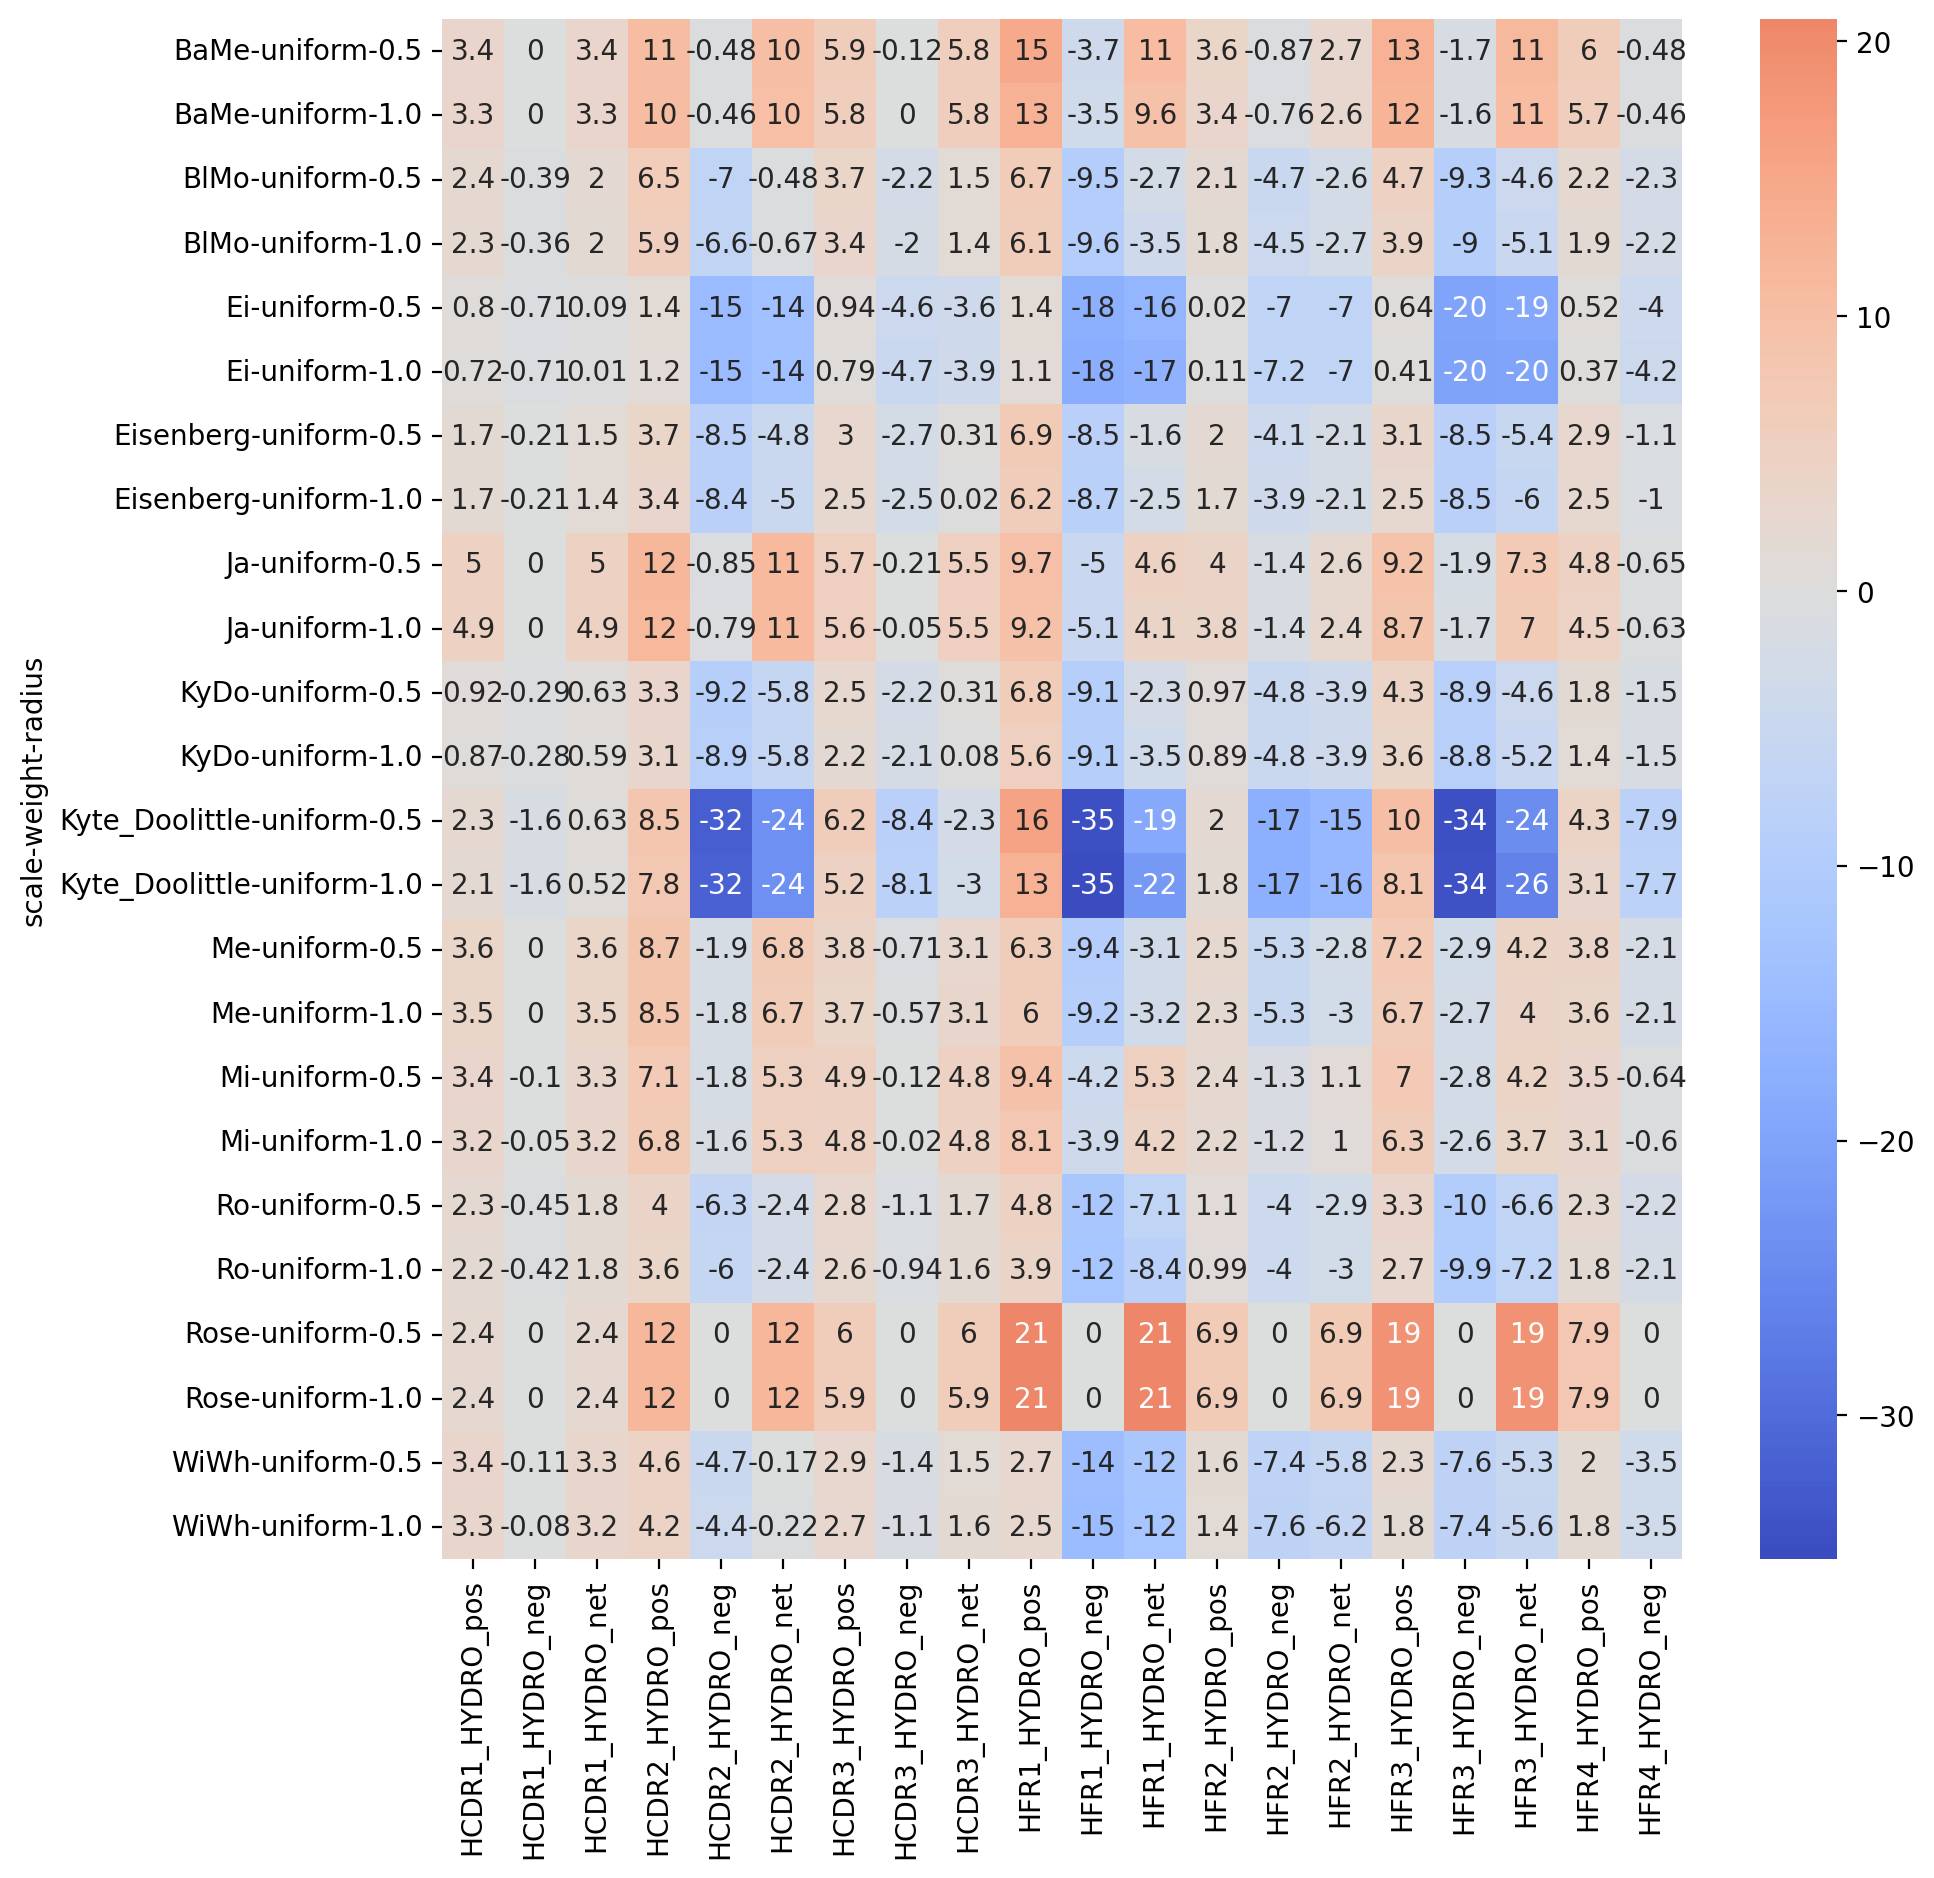

In [22]:
abituzumab = np.round(results_df.loc['abituzumab'],2)
figure = plt.figure(figsize=(10, 10))
sns.heatmap(abituzumab.iloc[:, :20], cmap='coolwarm', center=0, annot=True)

<Axes: ylabel='scale,weight,radius'>

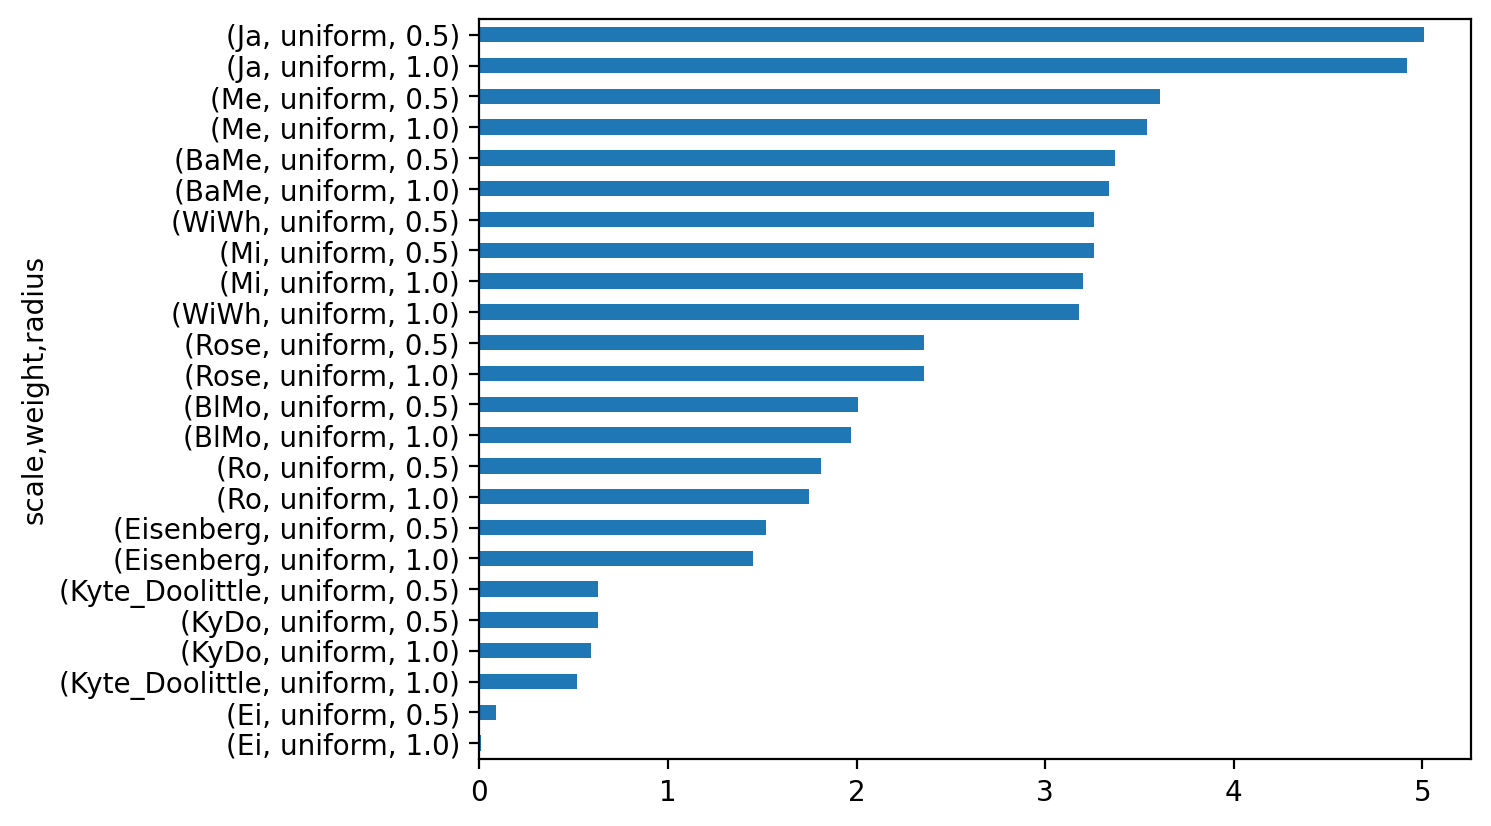

In [27]:
abituzumab['HCDR1_HYDRO_net'].sort_values().plot(kind = 'barh')